## Solving bidomain equations on the slice with the Beeler-Reuter model

### Importing required libraries

In [1]:
%cd ../../..
from src.models.dynamics_models import *
from src.models.cell_models import *
from src.utils import *
import ufl

/home/drvinko/Desktop/Modeliranje-biofizike-srcanog-tkiva


### Defining a domain, cell model and dynamics model and visualizing initial data

In [2]:
domain = heart_slice()
x = ufl.SpatialCoordinate(domain)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 40%] Meshing curve 2 (Nurb)
Info    : [ 70%] Meshing curve 3 (Nurb)
Info    : Done meshing 1D (Wall 0.0240261s, CPU 0.024105s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.060153s, CPU 0.059846s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 2.7824e-05s, CPU 1.4e-05s)
Info    : 3628 nodes 7231 elements


In [3]:
class CellModel(BeelerReuter):
    def apply_current(self):
        locator1 = lambda x: (x[0] - 0.1) ** 2 + (x[1] - 2.3) ** 2 < 0.5**2
        locator2 = lambda x: (x[0] - 1.3) ** 2 + (x[1] - 1.5) ** 2 < 0.5**2
        locator3 = lambda x: (x[0] - 3.3) ** 2 + (x[1] - 3.1) ** 2 < 0.3**2
        cells1 = fem.locate_dofs_geometrical(self.V1, locator1)
        cells2 = fem.locate_dofs_geometrical(self.V1, locator2)
        cells3 = fem.locate_dofs_geometrical(self.V1, locator3)
        self.I_app.x.array[cells1] = np.full_like(cells1, 10)
        self.I_app.x.array[cells2] = np.full_like(cells2, 10)
        self.I_app.x.array[cells3] = np.full_like(cells3, 10)
        self.I_app_duration = 20

In [4]:
class Model(BidomainModel):
    def initial_V_m(self):
        self.V_m_n.x.array[:] = -85

    def conductivity(self):
        # Muscle fibres
        x_c, y_c = 0.2, 1
        self.fibers = ufl.as_vector(
            [
                -(x[1] - y_c) / ufl.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
                (x[0] - x_c) / ufl.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
            ]
        )

        # Healthy conductivities
        self.M_i = self.SIGMA_IT * ufl.Identity(2) + (
            self.SIGMA_IL - self.SIGMA_IT
        ) * ufl.outer(self.fibers, self.fibers)
        self.M_e = self.SIGMA_ET * ufl.Identity(2) + (
            self.SIGMA_EL - self.SIGMA_ET
        ) * ufl.outer(self.fibers, self.fibers)

In [5]:
cell_model = CellModel(domain)
model = Model(domain, cell_model)

In [6]:
cell_model.plot_I_app(
    show_mesh=False,
    function_name="",
    camera_direction="xy",
    save_to="figures/slice/bidomain_BR_applied_current.pdf",
)

Widget(value='<iframe src="http://localhost:45559/index.html?ui=P_0x7fd9aa0f4890_0&reconnect=auto" class="pyvi…

### Solving equations with given parameters

In [7]:
model.solve(
    T=400,
    steps=10000,
    save_to="slice/bidomain_BR.mp4",
    signal_point=[1.0, 3.0, 0.0],
    camera_direction="xy",
    checkpoints=[35,85,230,300],
    checkpoint_file='figures/slice/bidomain_BR'
)

Solving problem: 100%|██████████| 10000/10000 [2:00:46<00:00,  1.38it/s] 


### Plotting a fiber orientations

In [11]:
x_c, y_c = 0.2, 1
plot_vector_field(
    domain,
    lambda x: (
        -(x[1] - y_c) / np.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        (x[0] - x_c) / np.sqrt((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        0,
    ),
    0.03,
    0.3,
    camera_direction='xy',
    save_to='figures/slice/bidomain_BR_fibers.pdf'
)

Widget(value='<iframe src="http://localhost:45559/index.html?ui=P_0x7fd903690290_3&reconnect=auto" class="pyvi…

### Plotting a final plot of transmembrane potential

In [9]:
plot_function(model.V_m_n, "V_m", show_mesh=False)

### Plotting a transmembrane potential in a given signal point

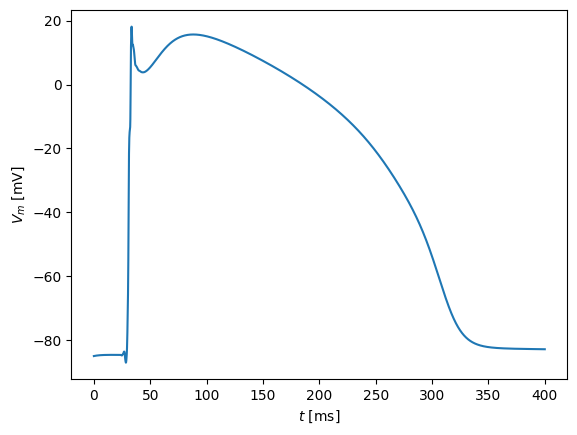

ERROR:wslink.protocol:Exception raised
ERROR:wslink.protocol:KeyError('4429df4c4d9b3e97ecf0a0c101ae062c_13957d')
ERROR:wslink.protocol:Traceback (most recent call last):
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/wslink/protocol.py", line 332, in onMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/drvinko/miniconda3/envs/diplomski/lib/python3.11/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 30, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: '4429df4c4d9b3e97ecf0a0c101ae062c_13957d'



In [10]:
model.plot_signal()